In [1]:
import torch
from coati.models.io.coati import load_e3gnn_smiles_clip_e2e

# Model parameters are pulled from the url and stored in a local models/ dir.
encoder, tokenizer = load_e3gnn_smiles_clip_e2e(
    freeze=True,
    device=torch.device("cuda:0"), 
    # model parameters to load.
    doc_url="s3://terray-public/models/barlow_closed.pkl",
)

Loading model from s3://terray-public/models/barlow_closed.pkl
Loading tokenizer may_closedparen from s3://terray-public/models/barlow_closed.pkl
number of parameters: 12.64M
number of parameters Total: 2.44M xformer: 17.92M Total: 20.36M 
vocab_name not found in tokenizer_vocabs, trying to load from file
Freezing encoder
20561664 params frozen!


In [2]:
# embed a single SMILES! 
from coati.generative.coati_purifications import embed_smiles
from rdkit import Chem
smiles = Chem.CanonSmiles("O=C(C)Oc1ccccc1C(=O)O")
vector = embed_smiles(smiles, encoder, tokenizer)


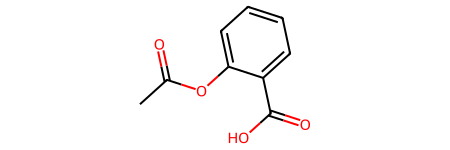

In [3]:
Chem.MolFromSmiles(smiles)

In [4]:
# embed a batch of SMILES!
from coati.generative.coati_purifications import embed_smiles_batch

raw_smiles = ["c1ccccc1", "O=C(C)Oc1ccccc1C(=O)O"]
smiles_batch = [Chem.CanonSmiles(smile) for smile in raw_smiles]

vecs = embed_smiles_batch(smiles_batch, encoder, tokenizer)

In [5]:
# reconstruct the original SMILES!
reconstructed_smiles = encoder.hclip_to_2d_batch(
    h_clip=vector.unsqueeze(0),
    tokenizer=tokenizer,
    noise_scale=0.0,
)

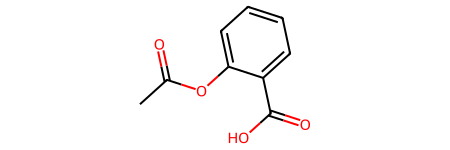

In [6]:
Chem.MolFromSmiles(reconstructed_smiles[0])

In [7]:
# prepare CHEMBL data
from coati.common.s3 import cache_read
import random
import pickle


# load Chembl dataset smile strings.
with cache_read("s3://terray-public/datasets/chembl_canonical_smiles.pkl", "rb") as f:
    chembl_canonical_smiles = pickle.loads(f.read(), encoding="UTF-8")
# for our example, we will use a small subset of the data
random.shuffle(chembl_canonical_smiles)
chembl_subset = chembl_canonical_smiles[:10_000]
chembl_subset = [{"smiles": s, "source": "chembl_mols", "qed": Chem.QED.qed(Chem.MolFromSmiles(s))} for s in chembl_subset]

In [8]:
# add embeddings! 
from coati.common.util import batch_indexable

for batch in batch_indexable(chembl_subset, 1024):
    batch_smi = [x["smiles"] for x in batch]
    batch_vecs = embed_smiles_batch(batch_smi, encoder, tokenizer)
    for i, entry in enumerate(batch):
        entry["coati_embed"] = batch_vecs[i, :].cpu().numpy()

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import numpy as np

train_entries, test_entries = train_test_split(chembl_subset, test_size=0.2, random_state=42)

# train a simple model to predict QED from the embeddings!
train_x = np.vstack([x["coati_embed"] for x in train_entries])
train_y = np.array([x["qed"] for x in train_entries])

test_x = np.vstack([x["coati_embed"] for x in test_entries])
test_y = np.array([x["qed"] for x in test_entries])

model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
model.fit(train_x, train_y)

preds = model.predict(test_x)

print(f"R2: {r2_score(test_y, preds)}")



R2: 0.7063645375447969


In [10]:
num_variations = 30
# noise is added as an isotropic Gaussian with std=noise_scale.
noise_scale = 0.3
nearby_smiles = encoder.hclip_to_2d_batch(
    h_clip=vector.unsqueeze(0).repeat(num_variations, 1),
    tokenizer=tokenizer,
    noise_scale=0.5,
)

unique_valid_smiles = set([smi for smi in nearby_smiles if Chem.MolFromSmiles(smi)])


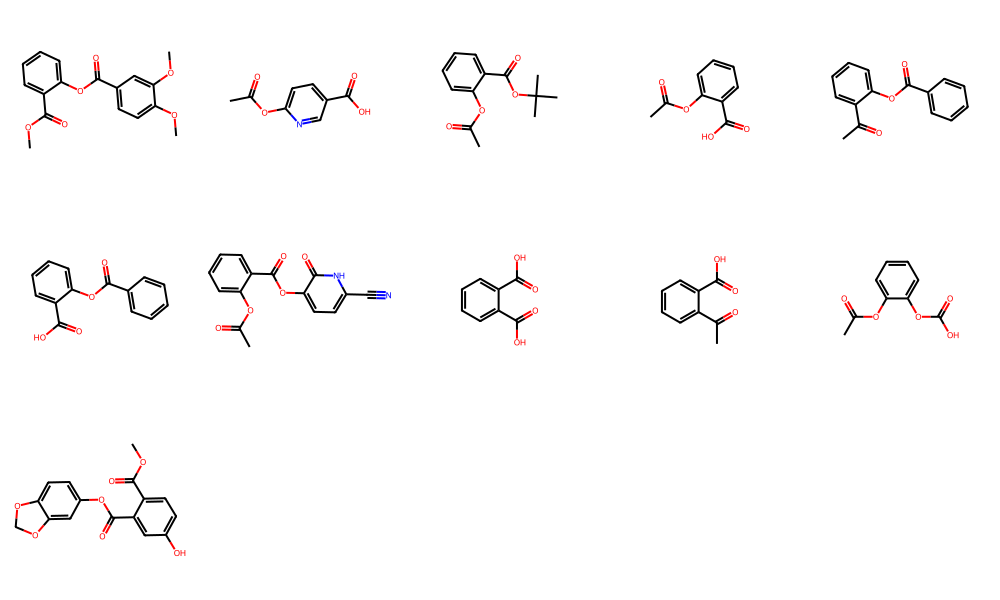

In [11]:
from rdkit.Chem import Draw
Draw.MolsToGridImage([Chem.MolFromSmiles(s) for s in unique_valid_smiles], molsPerRow=5, subImgSize=(200, 200))

In [12]:
num_variations = 30
noise_scale = 0.3
nearby_smiles = encoder.hclip_to_2d_batch(
    h_clip=vector.unsqueeze(0).repeat(num_variations, 1),
    tokenizer=tokenizer,
    noise_scale=0.25,
)

unique_valid_smiles = set([smi for smi in nearby_smiles if Chem.MolFromSmiles(smi)])


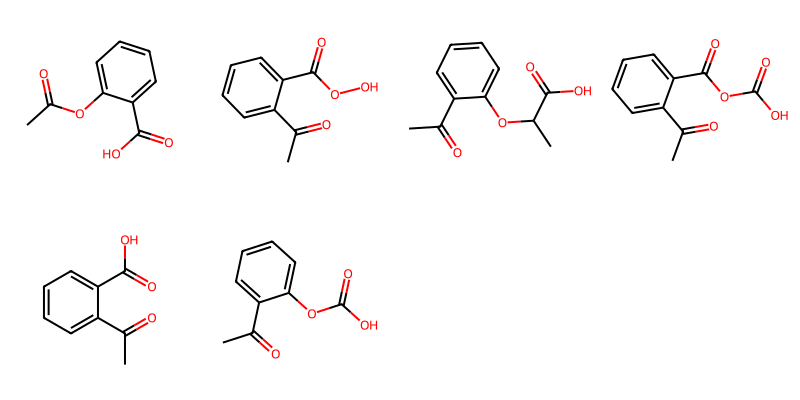

In [13]:
from rdkit.Chem import Draw
Draw.MolsToGridImage([Chem.MolFromSmiles(s) for s in unique_valid_smiles], molsPerRow=4, subImgSize=(200, 200))

In [14]:
unique_valid_smiles

{'CC(=O)Oc1ccccc1C(=O)O',
 'CC(=O)c1ccccc1C(=O)O',
 'CC(=O)c1ccccc1C(=O)OC(=O)O',
 'CC(=O)c1ccccc1C(=O)OO',
 'CC(=O)c1ccccc1OC(=O)O',
 'CC(=O)c1ccccc1OC(C)C(=O)O'}